Problem 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import requests
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 30
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


In [3]:
import torch.nn as nn

# Defining the RNN model
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        return output

In [4]:
# Defining the LSTM model
class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size 
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

In [5]:
# Defining the GRU model
class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output 

In [6]:
def train(model, epochs, optimizer, criterion, train_loader, test_loader):
    train_losses = []
    val_accuracies = []
    start_time = time.time()
    initial_start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        print(f'Epoch [{epoch}/{epochs}], '
              f'Training Loss: {train_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy*100:.2f}%'
              f', Time: {end_time - start_time:.2f}s')
        start_time = time.time()
    
    final_end_time = time.time()
    total_train_time = final_end_time - initial_start_time
    print("=======================================================================================================================")
    return train_losses, val_accuracies, total_train_time


In [7]:
# # Prediction function
# def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
#     model.eval()
#     with torch.no_grad():
#         initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
#         prediction = model(initial_input)
#         predicted_index = torch.argmax(prediction, dim=1).item()
#         return ix_to_char[predicted_index]

In [8]:
# Hyperparameters
hidden_size = 256
learning_rate = 0.001
epochs = 10
length_dataset = len(chars)
# Model Definitions
# RNN_model = CharRNN(len(dataset), hidden_size, len(dataset)).to(device)
LSTM_model = CharLSTM(length_dataset, hidden_size, length_dataset).to(device)
GRU_model = CharGRU(length_dataset, hidden_size, length_dataset).to(device)
criterion = nn.CrossEntropyLoss()

# stats_RNN =summary(
#     RNN_model,
#     (sequence_length, len(dataset)),
#     dtypes=[torch.long],
#     verbose=2,
#     col_width=16,
#     device=device,
#     col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
#     row_settings=["var_names"],
# )

# stats_LSTM =summary(
#     LSTM_model,
#     (sequence_length, len(dataset)),
#     dtypes=[torch.long],
#     verbose=2,
#     col_width=16,
#     device=device,
#     col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
#     row_settings=["var_names"],
# )

# stats_GRU =summary(
#     GRU_model,
#     (sequence_length, len(dataset)),
#     dtypes=[torch.long],
#     verbose=2,
#     col_width=16,
#     device=device,
#     col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
#     row_settings=["var_names"],
# )


#Optimizers
# RNN_optimizer = optim.Adam(RNN_model.parameters(), lr=learning_rate)
LSTM_optimizer = optim.Adam(LSTM_model.parameters(), lr=learning_rate)
GRU_optimizer = optim.Adam(GRU_model.parameters(), lr=learning_rate)

# RNN_train_loss, RNN_val_loss, RNN_val_acc, RNN_time = train(RNN_model, epochs, RNN_optimizer, criterion, train_loader, test_loader)
LSTM_train_loss, LSTM_val_acc, LSTM_time = train(LSTM_model, epochs, LSTM_optimizer, criterion, train_loader, test_loader)
GRU_train_loss, GRU_val_acc, GRU_time = train(GRU_model, epochs, GRU_optimizer, criterion, train_loader, test_loader)

# print(f'Total trainign time for RNN {RNN_time:.2f} s')
print(f'Total trainign time for LSTM {LSTM_time:.2f} s')
print(f'Total trainign time for GRU {GRU_time:.2f} s')

Epoch [1/10], Training Loss: 1.7023, Validation Accuracy: 53.46%, Time: 142.54s
Epoch [2/10], Training Loss: 1.4760, Validation Accuracy: 55.59%, Time: 165.03s
Epoch [3/10], Training Loss: 1.4160, Validation Accuracy: 56.36%, Time: 166.89s
Epoch [4/10], Training Loss: 1.3803, Validation Accuracy: 56.95%, Time: 174.59s
Epoch [5/10], Training Loss: 1.3550, Validation Accuracy: 57.28%, Time: 153.51s
Epoch [6/10], Training Loss: 1.3353, Validation Accuracy: 57.54%, Time: 166.90s
Epoch [7/10], Training Loss: 1.3200, Validation Accuracy: 57.92%, Time: 158.93s
Epoch [8/10], Training Loss: 1.3066, Validation Accuracy: 57.75%, Time: 63.66s
Epoch [9/10], Training Loss: 1.2960, Validation Accuracy: 58.18%, Time: 90.52s
Epoch [10/10], Training Loss: 1.2876, Validation Accuracy: 58.00%, Time: 56.79s
Epoch [1/10], Training Loss: 1.6927, Validation Accuracy: 53.86%, Time: 53.01s
Epoch [2/10], Training Loss: 1.4968, Validation Accuracy: 54.98%, Time: 53.15s
Epoch [3/10], Training Loss: 1.4500, Validat

In [9]:
# test_str = " more sequence of text characte"
# predicted_char = predict_next_char(RNN_model.to("cpu"), char_to_ix, ix_to_char, test_str)
# print(f"Predicted next character: '{predicted_char}'")

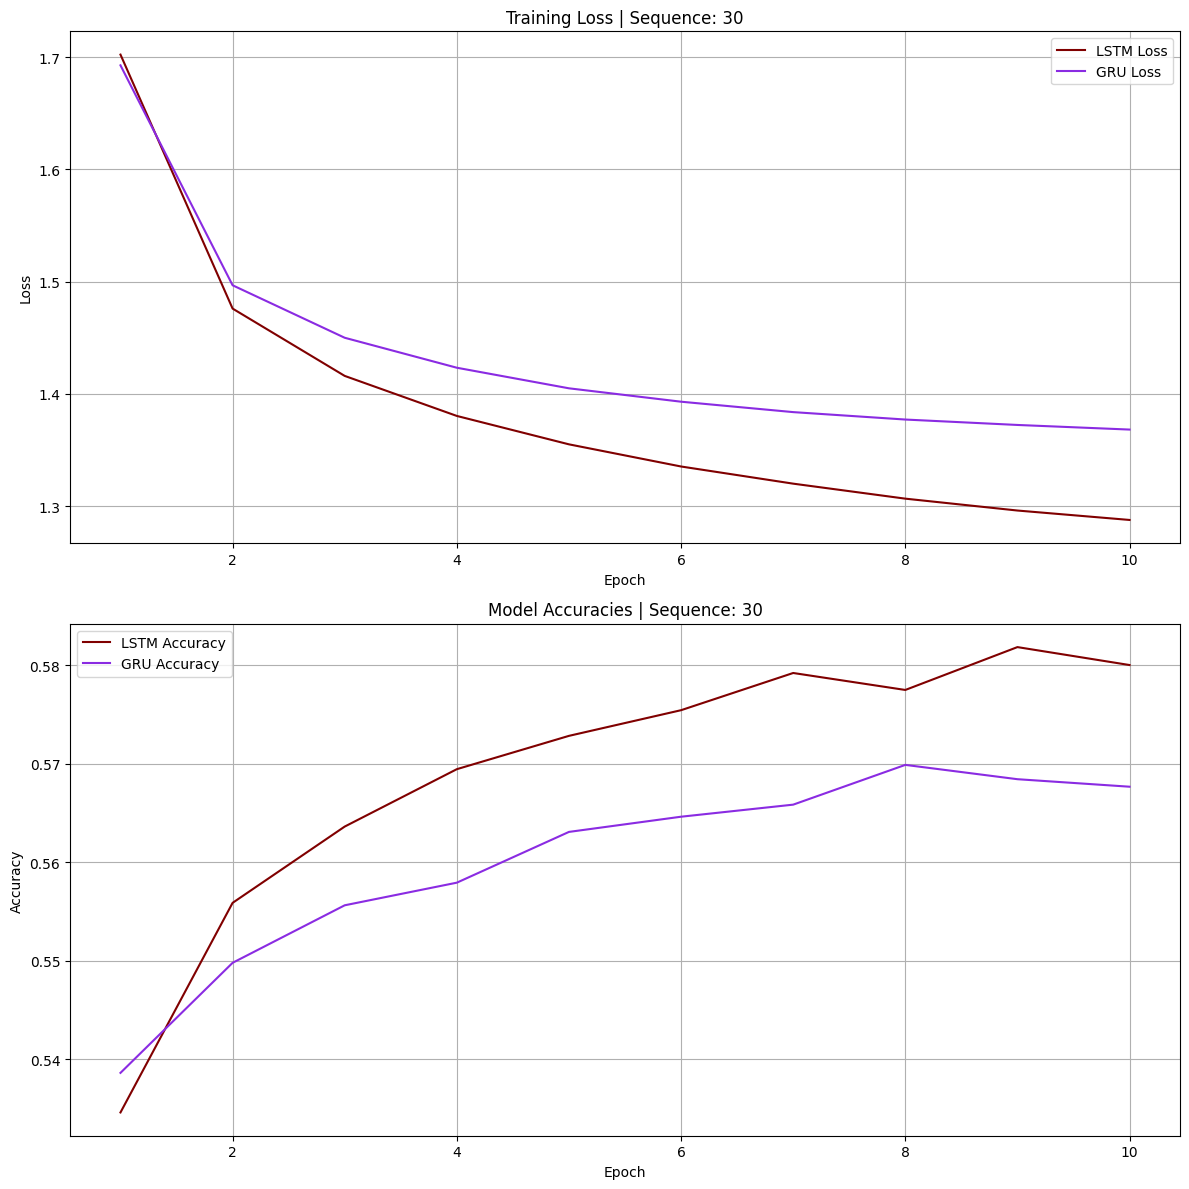

In [15]:
range_epochs = range(1, epochs+1)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
# plt.plot(range_epochs, RNN_train_loss, label='RNN Loss', color = 'forestgreen')
plt.plot(range_epochs, LSTM_train_loss, label='LSTM Loss', color = 'maroon')
plt.plot(range_epochs, GRU_train_loss, label='GRU Loss', color = 'blueviolet')
plt.title('Training Loss | Sequence: 30')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(visible=True)

plt.subplot(2, 1, 2)
# plt.plot(range_epochs, RNN_val_acc, label='RNN Accuracy', color = 'forestgreen')
plt.plot(range_epochs, LSTM_val_acc, label='LSTM Accuracy', color = 'maroon')
plt.plot(range_epochs, GRU_val_acc, label='GRU Accuracy', color = 'blueviolet')
plt.title('Model Accuracies | Sequence: 30')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(visible=True)
plt.tight_layout()

plt.savefig('ShakspearResultsS30.png')

In [12]:
stats_LSTM =summary(
    LSTM_model,
    (sequence_length, len(chars)),
    dtypes=[torch.long],
    verbose=2,
    col_width=16,
    device=device,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

stats_GRU =summary(
    GRU_model,
    (sequence_length, len(chars)),
    dtypes=[torch.long],
    verbose=2,
    col_width=16,
    device=device,
    col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
CharLSTM (CharLSTM)                      --               [30, 65]         --               --
├─Embedding (embedding)                  --               [30, 65, 256]    16,640           499,200
│    └─weight                            [256, 65]                         └─16,640
├─LSTM (lstm)                            --               [30, 65, 256]    526,336          1,026,355,200
│    └─weight_ih_l0                      [1024, 256]                       ├─262,144
│    └─weight_hh_l0                      [1024, 256]                       ├─262,144
│    └─bias_ih_l0                        [1024]                            ├─1,024
│    └─bias_hh_l0                        [1024]                            └─1,024
├─Linear (fc)                            --               [30, 65]         16,705           501,150
│    └─weight                            [256, 65]                         ├─